In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

## Parameters

In [2]:
USE_DATA_LEAK='Y' ## Set to Y to exploit the data leak
##
RAND_VAL=44
num_folds=7 ## Number of folds
n_est=5000 ## Number of estimators

## Read Train and Test Files

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')

In [4]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
df_test_ov = df_test.copy()
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


## Scaling

In [5]:
scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
###
for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c+"_scaled"] = (df_test[c] - min_value) / (max_value - min_value)

## TF-IDF Vectorization for Surname

In [6]:
df_train['Sur_Geo_Gend_Sal'] = df_train['CustomerId'].astype('str')+df_train['Surname']+df_train['Geography']+df_train['Gender']+np.round(df_train.EstimatedSalary).astype('str')
df_test['Sur_Geo_Gend_Sal'] = df_test['CustomerId'].astype('str')+df_test['Surname']+df_test['Geography']+df_test['Gender']+np.round(df_test.EstimatedSalary).astype('str')

In [7]:
def get_vectors(df_train,df_test,col_name):
    vectorizer = TfidfVectorizer(max_features=1000)
    vectors_train = vectorizer.fit_transform(df_train[col_name])
    vectors_test = vectorizer.transform(df_test[col_name])
    #
    svd = TruncatedSVD(3)
    x_pca_train = svd.fit_transform(vectors_train)
    x_pca_test = svd.transform(vectors_test)

    # Convert to DataFrames
    tfidf_df_train = pd.DataFrame(x_pca_train)
    tfidf_df_test = pd.DataFrame(x_pca_test)

    # Naming columns in the new DataFrames
    cols = [(col_name + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
    tfidf_df_train.columns = cols
    tfidf_df_test.columns = cols

    # Reset the index of the DataFrames before concatenation
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Concatenate transformed features with original data
    df_train = pd.concat([df_train, tfidf_df_train], axis="columns")
    df_test = pd.concat([df_test, tfidf_df_test], axis="columns")
    return df_train,df_test

In [8]:
df_train,df_test = get_vectors(df_train,df_test,'Surname')
df_train,df_test = get_vectors(df_train,df_test,'Sur_Geo_Gend_Sal')

## Feature Engineering

In [9]:
def getFeats(df):
    
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['len_SurName'] = df['Surname'].apply(lambda x: len(x))
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    
    cat_cols = ['Geography', 'Gender', 'NumOfProducts','AgeCat']
    df=pd.get_dummies(df,columns=cat_cols)
    return df

In [10]:
df_train = getFeats(df_train)
df_test = getFeats(df_test)
##
feat_cols=df_train.columns.drop(['id', 'CustomerId', 'Surname','Exited','Sur_Geo_Gend_Sal'])
feat_cols=feat_cols.drop(scale_cols)

print(feat_cols)
df_train.head()

Index(['Tenure', 'HasCrCard', 'IsActiveMember', 'Age_scaled',
       'CreditScore_scaled', 'Balance_scaled', 'EstimatedSalary_scaled',
       'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2',
       'Sur_Geo_Gend_Sal_tfidf_0', 'Sur_Geo_Gend_Sal_tfidf_1',
       'Sur_Geo_Gend_Sal_tfidf_2', 'IsSenior', 'IsActive_by_CreditCard',
       'Products_Per_Tenure', 'len_SurName', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male',
       'NumOfProducts_1', 'NumOfProducts_2', 'NumOfProducts_3',
       'NumOfProducts_4', 'AgeCat_1', 'AgeCat_2', 'AgeCat_3', 'AgeCat_4',
       'AgeCat_5'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,...,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,AgeCat_1,AgeCat_2,AgeCat_3,AgeCat_4,AgeCat_5
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,1.0,0.0,181449.97,...,True,False,True,False,False,False,True,False,False,False
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,1.0,1.0,49503.50,...,True,False,True,False,False,False,True,False,False,False
2,2,15694510,Hsueh,678,40.0,10,0.00,1.0,0.0,184866.69,...,True,False,True,False,False,False,True,False,False,False
3,3,15741417,Kao,581,34.0,2,148882.54,1.0,1.0,84560.88,...,True,True,False,False,False,False,True,False,False,False
4,4,15766172,Chiemenam,716,33.0,5,0.00,1.0,1.0,15068.83,...,True,False,True,False,False,False,True,False,False,False


In [11]:
X=df_train[feat_cols]
y=df_train['Exited']

## Parameters

In [12]:
lgbParams = {'n_estimators': n_est,
             'max_depth': 22, 
             'learning_rate': 0.025,
             'min_child_weight': 3.43,
             'min_child_samples': 216, 
             'subsample': 0.782,
             'subsample_freq': 4, 
             'colsample_bytree': 0.29, 
             'num_leaves': 21}

## Feature Importance

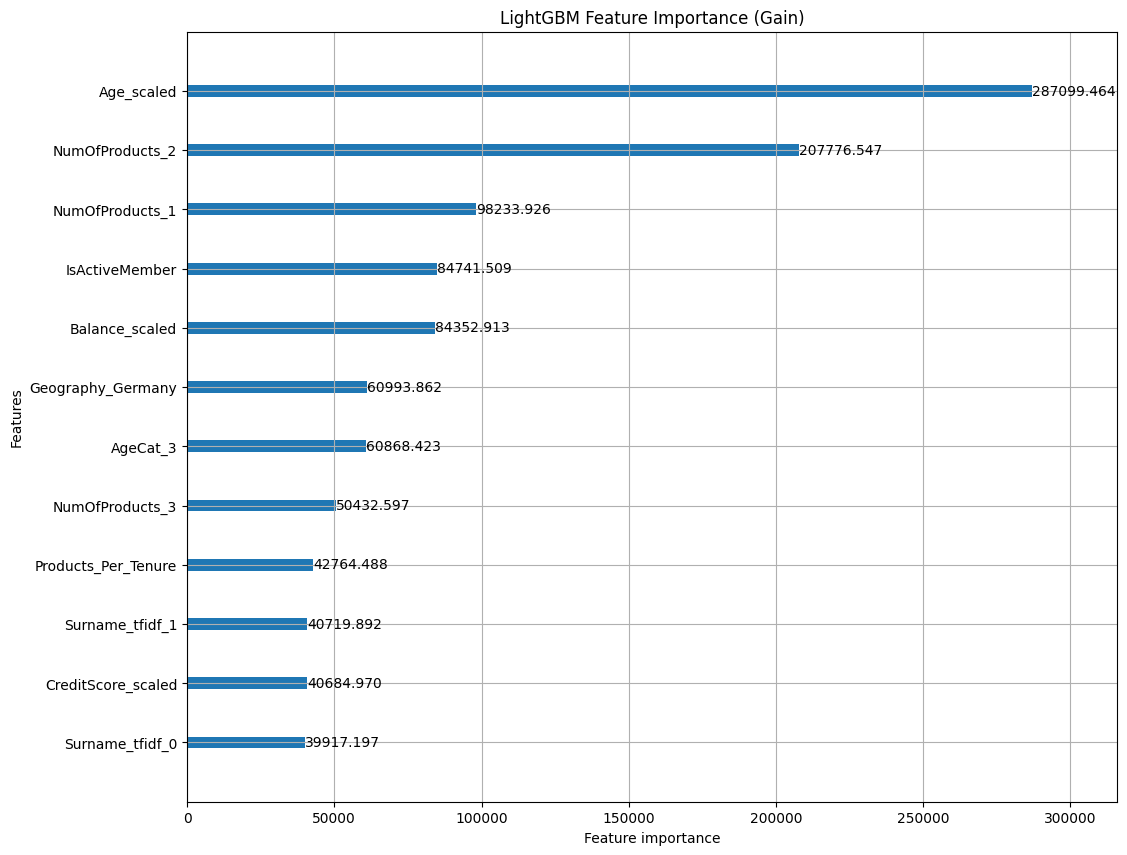

In [13]:
LGB=lgb.LGBMClassifier(**lgbParams)
LGB.fit(X,y)
lgb.plot_importance(LGB, importance_type="gain", figsize=(12,10), max_num_features=12,
                    title="LightGBM Feature Importance (Gain)")
plt.show()

## Training

In [14]:
folds = StratifiedKFold(n_splits=num_folds,random_state=RAND_VAL,shuffle=True)
test_preds = np.empty((num_folds, len(df_test)))
auc_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    LGB=lgb.LGBMClassifier(**lgbParams)
    LGB.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        early_stopping_rounds=100,verbose=200)
    
    y_pred_val = LGB.predict_proba(X_val[feat_cols])[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test = LGB.predict_proba(df_test[feat_cols])[:,1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

[200]	valid_0's auc: 0.887117	valid_0's binary_logloss: 0.327069
[400]	valid_0's auc: 0.89128	valid_0's binary_logloss: 0.317355
[600]	valid_0's auc: 0.892778	valid_0's binary_logloss: 0.314761
[800]	valid_0's auc: 0.893573	valid_0's binary_logloss: 0.313483
[1000]	valid_0's auc: 0.894013	valid_0's binary_logloss: 0.312713
[1200]	valid_0's auc: 0.894282	valid_0's binary_logloss: 0.312287
[1400]	valid_0's auc: 0.894544	valid_0's binary_logloss: 0.311898
[1600]	valid_0's auc: 0.894695	valid_0's binary_logloss: 0.311636
AUC for fold  0 :  0.8947418611886542
----------------
[200]	valid_0's auc: 0.885283	valid_0's binary_logloss: 0.32833
[400]	valid_0's auc: 0.889921	valid_0's binary_logloss: 0.318785
[600]	valid_0's auc: 0.891655	valid_0's binary_logloss: 0.316195
[800]	valid_0's auc: 0.892601	valid_0's binary_logloss: 0.31484
[1000]	valid_0's auc: 0.893105	valid_0's binary_logloss: 0.314173
[1200]	valid_0's auc: 0.8934	valid_0's binary_logloss: 0.313803
[1400]	valid_0's auc: 0.893571	val

## Evaluation

In [15]:
"Mean AUC: ",np.mean(auc_vals)

('Mean AUC: ', 0.895133894371049)

## Prediction and Submission

In [16]:
y_pred = test_preds.mean(axis=0)

## Override from Original Dataset.
### Credit : @paddykb
https://www.kaggle.com/competitions/playground-series-s4e1/discussion/469859

Added ~0.002 to LB score from data leakage.
Best LB score without override for this notebook is 0.89099

In [17]:
df_orig=pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")
join_cols=list(df_orig.columns.drop(['RowNumber','Exited']))
df_orig.rename(columns={'Exited':'Exited_Orig'},inplace=True)
df_orig['Exited_Orig']=df_orig['Exited_Orig'].map({0:1,1:0})
df_test_ov=df_test_ov.merge(df_orig,on=join_cols,how='left')[['id','Exited_Orig']].fillna(-1)
####
df_sub = df_test_ov[['id','Exited_Orig']]

if USE_DATA_LEAK=='Y':
    df_sub['Exited'] = np.where(df_sub.Exited_Orig==-1,y_pred,df_sub.Exited_Orig)
else:
    df_sub['Exited'] = y_pred
    
df_sub.drop('Exited_Orig',axis=1,inplace=True)
df_sub.head()

,id,Exited
0,165034,0.014419
1,165035,0.717834
2,165036,0.032950
3,165037,0.244962
4,165038,0.369782


In [18]:
df_sub.to_csv("submission.csv",index=False)

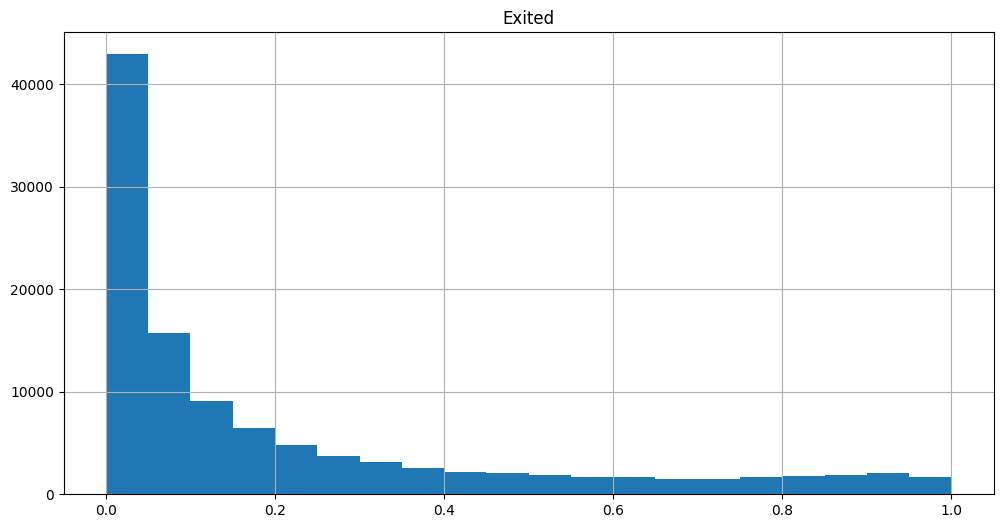

In [19]:
df_sub.hist(column='Exited', bins=20, range=[0,1],figsize=(12,6))
plt.show()